In [1]:
import h5py
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
from pathlib import Path
import pyfftw

import bacco

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import plotter
import plot_utils
import utils
import compute_statistics as cs
import data_loader
import generate_params as genp

%load_ext autoreload
%autoreload 2

2025-12-09 20:05:35.216786: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-09 20:05:35.332244: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-09 20:05:35.332283: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-09 20:05:35.357055: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-09 20:05:35.444918: I tensorflow/core/platform/cpu_feature_guar

In [4]:
data_mode = 'muchisimocks'
#statistics = ['pk', 'bispec']
statistics = ['pk']

### train
# tag_params = '_p5_n10000'
# tag_biasparams = '_biaszen_p4_n10000'
# tag_noise = '_noise_p5_n10000'
# tag_Anoise = '_An_p1_n10000'
### test
tag_params = '_test_p5_n1000'
tag_biasparams = '_biaszen_p4_n1000'
tag_noise = '_noise_unit_test_p5_n1000'
tag_Anoise = '_Anmult_p2_n1000'
tag_datagen = ''
## cosmic variance (quijote)
# tag_params="_quijote_p0_n1000"
# tag_biasparams="_b1000_p0_n1"
# tag_noise="_noise_quijote_p0_n1000"
# tag_Anoise="_An1_p0_n1"
# tag_datagen = ''
kwargs_data = {
    'tag_datagen': tag_datagen
}

tag_stats = f'_{"_".join(statistics)}'    
tag_data = '_'+data_mode + tag_stats + tag_params + tag_biasparams + tag_datagen
k_arr, y_arr, y_err, idxs_params, params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = \
            data_loader.load_data(data_mode, statistics, 
                                    tag_params, tag_biasparams,
                                    tag_noise=tag_noise, tag_Anoise=tag_Anoise,
                                    tag_data=tag_data,
                                    kwargs=kwargs_data)
            
print(y_arr[0].shape)
#print(y_arr[1].shape)

dir_statistics: /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p2_n1000
Loading muchisimocks data from /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p2_n1000
Found 26 diff cosmo pks in /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p2_n1000
Loaded pk data with shape (26, 30)
fn_mask: ../data/masks/mask_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000.txt
Loading from ../data/masks/mask_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000.txt (already exists)
Masked 1 out of 30 bins
(29,) (26, 30) (26, 30) (30,)
(26, 29)


In [5]:
mask = data_loader.get_Pk_mask(tag_data)

fn_mask: ../data/masks/mask_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000.txt
Loading from ../data/masks/mask_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000.txt (already exists)


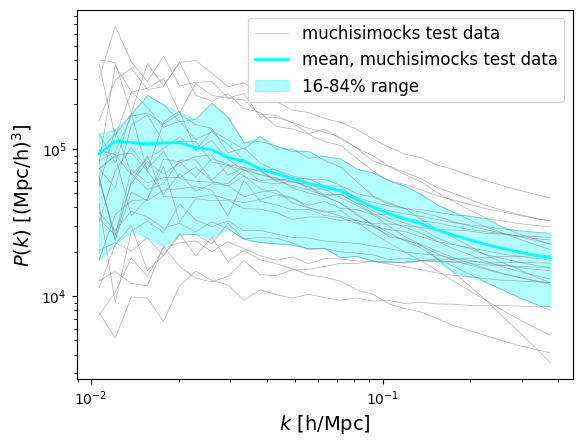

In [7]:
# unpack the power spectrum
k_pk = k_arr[statistics.index('pk')]
y_pk = y_arr[statistics.index('pk')]

n_plot = np.min([100, y_pk.shape[0]])
first = True
for i in range(n_plot):
    if first:
        label = 'muchisimocks test data'
        first = False
    else:
        label = None
    plt.plot(k_pk, y_pk[i], color='grey', alpha=0.6, lw=0.5, label=label)

mean = np.mean(y_pk, axis=0)
p16 = np.percentile(y_pk, 16, axis=0)
p84 = np.percentile(y_pk, 84, axis=0)
plt.plot(k_pk, mean, color='cyan', lw=2, label='mean, muchisimocks test data')
plt.fill_between(k_pk, p16, p84, color='cyan', alpha=0.3, label=r'16-84% range')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=14)
plt.legend(fontsize=12)

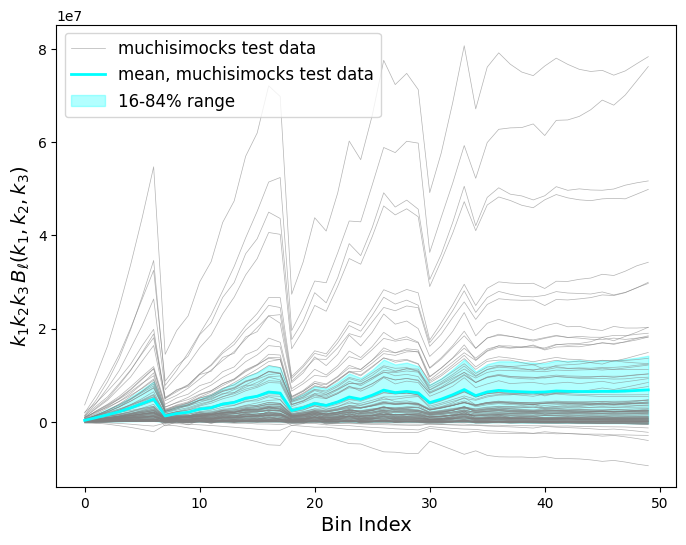

In [49]:
k_bispec = k_arr[statistics.index('bispec')]
y_bispec = y_arr[statistics.index('bispec')]

plt.figure(figsize=(8,6))

n_plot = 100
first = True
for i in range(n_plot):
    if first:
        label = 'muchisimocks test data'
        first = False
    else:
        label = None
    plt.plot(range(len(y_bispec[i])), y_bispec[i], color='grey', alpha=0.6, lw=0.5, label=label)

mean = np.mean(y_bispec, axis=0)
p16 = np.percentile(y_bispec, 16, axis=0)
p84 = np.percentile(y_bispec, 84, axis=0)
plt.plot(range(len(mean)), mean, color='cyan', lw=2, label='mean, muchisimocks test data')
plt.fill_between(range(len(mean)), p16, p84, color='cyan', alpha=0.3, label=r'16-84% range')

plt.xlabel(r'Bin Index', fontsize=14)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$', fontsize=14)
plt.legend(fontsize=12)

In [ ]:
plt.figure(figsize=(8,6))

# ks & norm same for all
k123 = bspec.get_ks()
weight = k123.prod(axis=0)

norm = n_grid**3
norm_mock = n_grid_mock**3
print(norm, norm_mock)

i = 1
k_mock = k_mock_arr[i]
y_mock = y_mock_arr[i]

bk_corr = bk_corr_arr[i]

label = f'SHAMe mock, nbar={tag_mock.split("nbar")[-1]}'
label_muchisimocks = 'muchisimocks with parameters\nof SHAMe truth'
label_muchisimocks_noiseless = 'muchisimocks but noiseless'

plt.plot(y_mock[1], color=colors[i], label=label)
plt.plot(norm**3 * weight*bk_corr['b0'], color=colors[i], ls='--', lw=1, label=label_muchisimocks)
plt.plot(norm**3 * weight*bk_corr_noiseless_arr[i]['b0'], color=colors[i], lw=2.5, ls=':', label=label_muchisimocks_noiseless)


plt.plot(norm**3 * weight*bispec_noise0s, color='navy', ls='-.', lw=1,
         label='noise model (eps=0)')
plt.plot(norm**3 * weight*(bk_corr_noiseless_arr[i]['b0']+bispec_noise0s),
         color='navy', ls='-', lw=1, 
         #label='noiseless + noise model (fit incl higher order terms)'
         )

plt.plot(norm**3 * weight*fit_term0['model_bispectrum'], color='silver', ls='-.', lw=1,
         label='noise model (fit shot noise term)')
plt.plot(norm**3 * weight*(bk_corr_noiseless_arr[i]['b0']+fit_term0['model_bispectrum']), 
         color='silver', ls='-', lw=1, 
         label='noiseless + noise model')




#plt.plot(norm**3 * weight*bispec_noise, color='grey', ls='-.', lw=2, label='bispectrum noise model')

plt.xlabel(r'Bin Index',fontsize=15)
plt.ylabel(r'$k_1k_2k_3\,B_\ell(k_1,k_2,k_3)$',fontsize=15)
plt.legend(fontsize=10)
        

### noiseless

In [39]:
data_mode = 'muchisimocks'
statistics = ['pk']

### train
# tag_params = '_p5_n10000'
# tag_biasparams = '_biaszen_p4_n10000'
# tag_noise = '_noise_p5_n10000'
# tag_Anoise = '_An_p1_n10000'
### test
tag_params = '_test_p5_n1000'
tag_biasparams = '_biaszen_p4_n1000'
#tag_noise = '_noise_unit_test_p5_n1000'
#tag_Anoise = '_Anmult_p1_n1000'
tag_noise = None
tag_Anoise = None
#tag_datagen = ''
## cosmic variance (quijote)
# tag_params="_quijote_p0_n1000"
# tag_biasparams="_b1000_p0_n1"
# tag_noise="_noise_quijote_p0_n1000"
# tag_Anoise="_An1_p0_n1"
# tag_datagen = ''
kwargs_data = {
    'tag_datagen': tag_datagen
}

tag_stats = f'_{"_".join(statistics)}'    
tag_data = '_'+data_mode + tag_stats + tag_params + tag_biasparams + tag_datagen
k, y, y_err, idxs_params, params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = \
            data_loader.load_data(data_mode, statistics, 
                                    tag_params, tag_biasparams,
                                    tag_noise=tag_noise, tag_Anoise=tag_Anoise,
                                    tag_data=tag_data,
                                    kwargs=kwargs_data)
            
# unpack the power spectrum
k, y, y_err = k[0], y[0], y_err[0]
print(y.shape)
print(k.shape)

dir_statistics: /scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_test_p5_n1000_biaszen_p4_n1000
Loading muchisimocks data from /scratch/kstoreyf/muchisimocks/data/pnns_mlib/pnns_test_p5_n1000
Found 1000 diff cosmo pnns in /scratch/kstoreyf/muchisimocks/data/pnns_mlib/pnns_test_p5_n1000
idx_LH=0
idx_LH=1
idx_LH=2
idx_LH=3
idx_LH=4
idx_LH=5
idx_LH=6
idx_LH=7
idx_LH=8
idx_LH=9
idx_LH=10
idx_LH=11
idx_LH=12
idx_LH=13
idx_LH=14
idx_LH=15
idx_LH=16
idx_LH=17
idx_LH=18
idx_LH=19
idx_LH=20
idx_LH=21
idx_LH=22
idx_LH=23
idx_LH=24
idx_LH=25
idx_LH=26
idx_LH=27
idx_LH=28
idx_LH=29
idx_LH=30
idx_LH=31
idx_LH=32
idx_LH=33
idx_LH=34
idx_LH=35
idx_LH=36
idx_LH=37
idx_LH=38
idx_LH=39
idx_LH=40
idx_LH=41
idx_LH=42
idx_LH=43
idx_LH=44
idx_LH=45
idx_LH=46
idx_LH=47


OSError: [Errno 121] Remote I/O error

In [ ]:
mask = data_loader.get_Pk_mask(tag_data)

fn_mask: ../data/masks/mask_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000.txt
Loading from ../data/masks/mask_muchisimocks_pk_test_p5_n1000_biaszen_p4_n1000.txt (already exists)


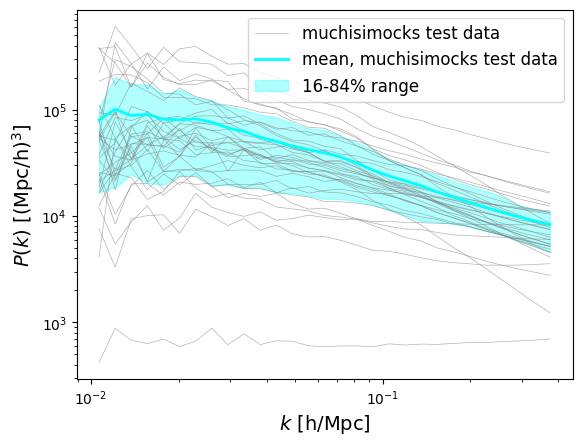

In [ ]:
#n_plot = 100
n_plot = y.shape[0]
first = True
for i in range(n_plot):
    if first:
        label = 'muchisimocks test data'
        first = False
    else:
        label = None
    plt.plot(k, y[i], color='grey', alpha=0.6, lw=0.5, label=label)

mean = np.mean(y, axis=0)
p16 = np.percentile(y, 16, axis=0)
p84 = np.percentile(y, 84, axis=0)
plt.plot(k, mean, color='cyan', lw=2, label='mean, muchisimocks test data')
plt.fill_between(k, p16, p84, color='cyan', alpha=0.3, label=r'16-84% range')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ [h/Mpc]', fontsize=14)
plt.ylabel(r'$P(k)$ [(Mpc/h)$^3$]', fontsize=14)
plt.legend(fontsize=12)

In [ ]:
for i in range(1000):
    fn = f'/scratch/kstoreyf/muchisimocks/muchisimocks_lib_test_p5_n1000/LH{i}/bias_fields_eul_deconvolved_{i}.npy'
    try:
        fields = np.load(fn)
        #print(fields.shape)
    except Exception as e:
        print(f"Failed to load {fn}: {e}")

Failed to load /scratch/kstoreyf/muchisimocks/muchisimocks_lib_test_p5_n1000/LH7/bias_fields_eul_deconvolved_7.npy: cannot reshape array of size 2016 into shape (5,128,128,128)
Failed to load /scratch/kstoreyf/muchisimocks/muchisimocks_lib_test_p5_n1000/LH20/bias_fields_eul_deconvolved_20.npy: cannot reshape array of size 2016 into shape (5,128,128,128)
Failed to load /scratch/kstoreyf/muchisimocks/muchisimocks_lib_test_p5_n1000/LH21/bias_fields_eul_deconvolved_21.npy: cannot reshape array of size 2016 into shape (5,128,128,128)
Failed to load /scratch/kstoreyf/muchisimocks/muchisimocks_lib_test_p5_n1000/LH23/bias_fields_eul_deconvolved_23.npy: cannot reshape array of size 2016 into shape (5,128,128,128)
Failed to load /scratch/kstoreyf/muchisimocks/muchisimocks_lib_test_p5_n1000/LH72/bias_fields_eul_deconvolved_72.npy: cannot reshape array of size 2016 into shape (5,128,128,128)
Failed to load /scratch/kstoreyf/muchisimocks/muchisimocks_lib_test_p5_n1000/LH76/bias_fields_eul_deconvolv

KeyboardInterrupt: 

In [14]:
for i in range(100):
    fn = f'/scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH{i}/bias_fields_eul_deconvolved_{i}.npy'
    try:
        fields = np.load(fn, mmap_mode='r')
        #print(fields.shape)
    except Exception as e:
        print(f"Failed to load {fn}: {e}")

Failed to load /scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH49/bias_fields_eul_deconvolved_49.npy: [Errno 121] Remote I/O error
Failed to load /scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH65/bias_fields_eul_deconvolved_65.npy: [Errno 121] Remote I/O error
Failed to load /scratch/kstoreyf/muchisimocks/muchisimocks_lib_p5_n10000/LH76/bias_fields_eul_deconvolved_76.npy: [Errno 121] Remote I/O error


In [19]:
for i in range(1000):
    fn = f'/scratch/kstoreyf/muchisimocks/muchisimocks_lib_test_p5_n1000/LH{i}/bias_fields_eul_deconvolved_{i}.npy'
    try:
        fields = np.load(fn)
        #print(i, fields.shape)
    except Exception as e:
        pass
        print(f"Failed to load {fn}: {e}")

In [38]:

for i in range(100):
    fn_pk = f'/scratch/kstoreyf/muchisimocks/data/pks_mlib/pks_test_p5_n1000_biaszen_p4_n1000_noise_unit_test_p5_n1000_Anmult_p1_n1000/pk_{i}_b{i}_n{i}.npy'
    try:
        pk = np.load(fn_pk, allow_pickle=True)
    except Exception as e:
        print(f"Failed to load {i}")
        continue

Failed to load 15
